In [1]:
%matplotlib notebook
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

import ipywidgets as widgets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

Matplotlib settings:

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

Load the data: HA (deg), Dec (deg), dome azimuth (deg), $\Delta$HA (the maximum hour angle distance; in hours).

In [3]:
ha, dec, az, delta_ha = np.loadtxt('optimal_az.csv', delimiter=',', unpack=True)

ha_shifted = np.where(ha < 0, ha + 360, ha) # offset ha, s.t. ha = (0, ..., 359)

# hd = np.column_stack([ha, dec])
hd = np.column_stack([ha_shifted, dec])

# Interpolation

In [4]:
def interp_opt(ha, dec):
    val = griddata(hd, az, (ha, dec), method='nearest')
    
    return val

Calculate the appropriate $A_d$:

In [5]:
# ha_range = np.linspace(ha.min(), ha.max(), 1000)
ha_range = np.linspace(ha_shifted.min(), ha_shifted.max(), 1000)
dec_range = np.linspace(dec.min(), dec.max(), 1000)

# Define a (ha, dec) grid
ha_target, dec_target = np.meshgrid(ha_range,dec_range)

# interpolate and calc optimal az
az_target = interp_opt(ha_target, dec_target)

# Plotting

## Interpolated...

<IPython.core.display.Javascript object>


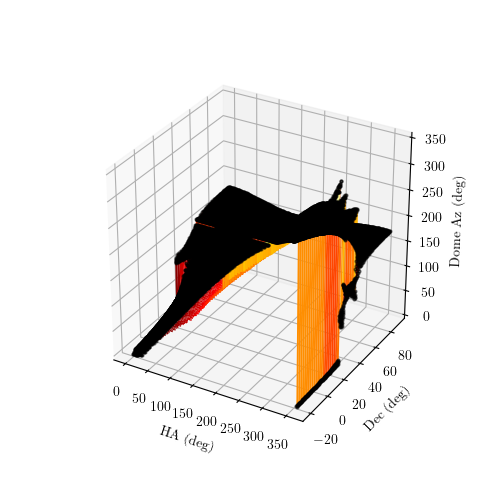

In [6]:
fig = plt.figure(figsize=(5, 5))
frame = fig.add_subplot(1, 1, 1, projection ='3d')

frame.grid(True, alpha=0.5)

frame.set_xlabel('HA (deg)')
frame.set_ylabel('Dec (deg)')
frame.set_zlabel('Dome Az (deg)')

frame.plot(ha_shifted, dec, az, color='black', ls='', alpha=0.5, marker='o', ms=2, zorder=10)
frame.plot_surface(ha_target, dec_target, az_target, rstride=20, cstride=20, cmap=cm.hot)

plt.show()

## Colormaps...

In [7]:
ha_range = np.arange(ha_shifted.min(), ha_shifted.max() + 1, 1)
dec_range = np.arange(dec.min(), dec.max() + 1, 1)

ha_grid, dec_grid = np.meshgrid(ha_range, dec_range, indexing='ij')

Create a $A_d$ grid for imshow from the 1D data...

In [8]:
az_grid = np.zeros(ha_grid.shape) * np.nan

for i in range(0, ha_range.size):
    for j in range(0, dec_range.size):
        h = ha_grid[i, j]
        d = dec_grid[i, j]
        
        sel = np.isclose(ha_shifted, h)&np.isclose(dec, d)
        if np.count_nonzero(sel) > 0:
            az_grid[i, j] = az[sel][0]
        else:
            az_grid[i, j] = np.nan

Create a $\Delta h$ grid for imshow from the 1D data...

In [9]:
delta_ha_grid = np.zeros(ha_grid.shape) * np.nan

for i in range(0, ha_range.size):
    for j in range(0, dec_range.size):
        h = ha_grid[i, j]
        d = dec_grid[i, j]
        
        sel = np.isclose(ha_shifted, h)&np.isclose(dec, d)
        if np.count_nonzero(sel) > 0:
            delta_ha_grid[i, j] = delta_ha[sel][0]
        else:
            delta_ha_grid[i, j] = np.nan

### Plotting $A_d=A_d(h,\delta)$

<IPython.core.display.Javascript object>


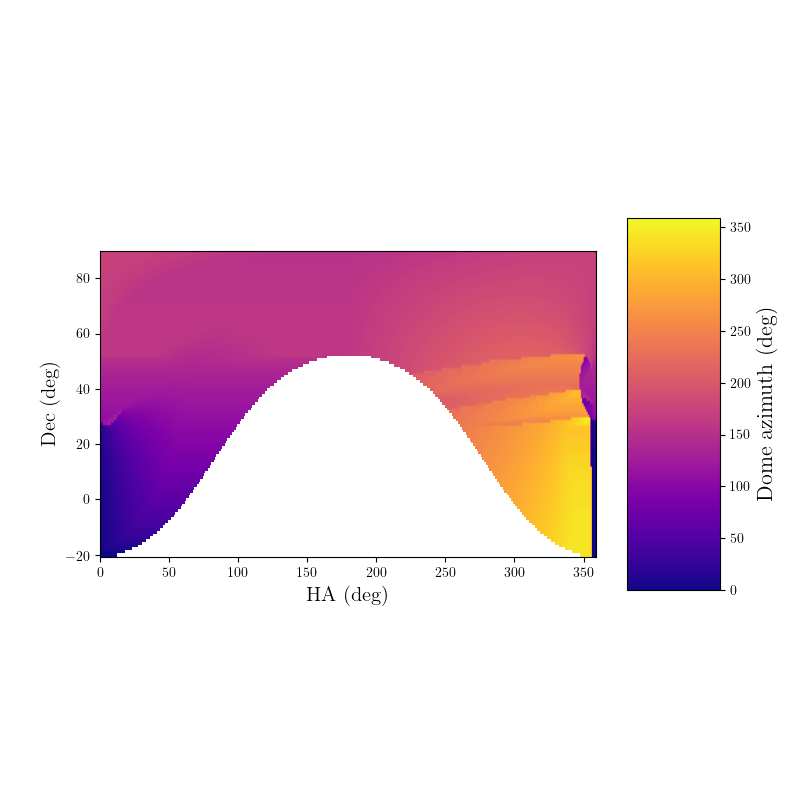

In [10]:
fig = plt.figure(figsize=(8, 8))
frame = fig.add_subplot(1, 1, 1)

frame.set_xlabel('HA (deg)', fontsize=15)
frame.set_ylabel('Dec (deg)', fontsize=15)

az_grid_transposed = az_grid.T
az_field = frame.imshow(az_grid_transposed, aspect=2, origin='lower', extent=(0, 359, -21, 90), 
                        vmin=0, vmax=359, cmap=cm.plasma)

col_bar = fig.colorbar(az_field, shrink=1, aspect=4)
col_bar.set_label('Dome azimuth (deg)', fontsize=16)

plt.show()

fig.savefig('images/optimal_azimuth.png', dpi=500)

### Time at each $(h,\delta)$

<IPython.core.display.Javascript object>


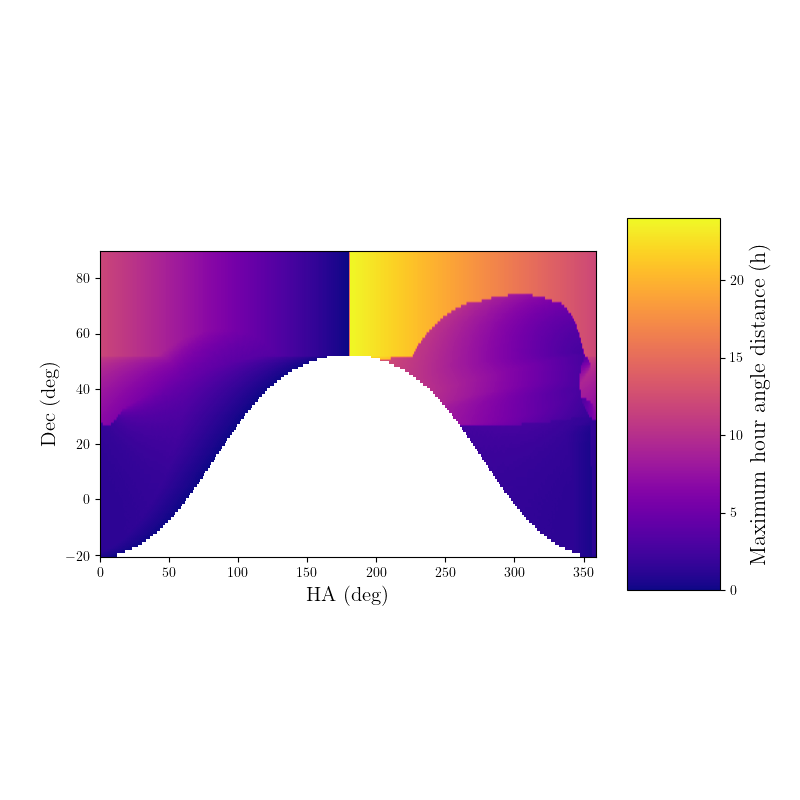

In [11]:
fig = plt.figure(figsize=(8, 8))
frame = fig.add_subplot(1, 1, 1)

frame.set_xlabel('HA (deg)', fontsize=15)
frame.set_ylabel('Dec (deg)', fontsize=15)

delta_ha_grid_transposed = delta_ha_grid.T
delta_ha_field = frame.imshow(delta_ha_grid_transposed, aspect=2, origin='lower', extent=(0, 359, -21, 90), 
                        vmin=0, vmax=24, cmap=cm.plasma)

col_bar = fig.colorbar(delta_ha_field, shrink=1, aspect=4)
col_bar.set_label('Maximum hour angle distance (h)', fontsize=16)

plt.show()

fig.savefig('images/max_hour_angle_distance.png', dpi=500)